<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/RL/DZ_2/start_train_DDQ_time_lstm_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение агента на среде [ViZDoom](https://github.com/mwydmuch/ViZDoom)

Сценарий - "защищай центр" (defend the center)

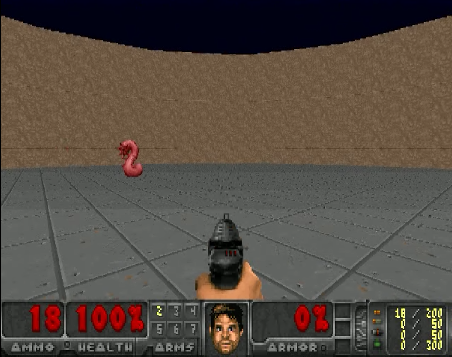

# Устанавливаем саму библиотеку ViZDoom из её гитхаб репозитории.

Для того, чтобы запустить среду ViZDoom в колаб-ноутбуке, нужно установить дополнительные программы, которые упомянаются в официальной [документации](https://vizdoom.farama.org/introduction/pythonQuickstart/).

Обычно уходит 3-5 минут на установку этой библиотеки.

In [ ]:
%%bash
# %%bash - значит используем командную строку (не код питона)
apt-get update
# Устанавливаем нужные программы, которая требует от нас документация
apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Устанавливаем библиотеку Boost
apt-get install libboost-all-dev

# Устанавливаем зависимости Lua
apt-get install liblua5.1-dev

# установку самой библиотеки.
pip install vizdoom

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [783 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,053 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,920 kB]
Hit:13 https://ppa.launch

## Cкачиваем нужный сценарий для среды ViZDoom.
Сценарий - "защищай центр" ([defend the center](https://vizdoom.farama.org/environments/default/))

**Брать файлы defend_the_center.cfg и defend_the_center.wad - можно отсюда**

https://github.com/Farama-Foundation/ViZDoom/blob/master/scenarios/defend_the_center.wad

In [ ]:
!pip install --upgrade --no-cache-dir gdown -q
# я себе записал
!gdown --id "18yFz4O3O1L8o4HZNDF899-fVdDHzOtcZ"
!unzip -qo /content/scenario.zip -d /content/ # Разархивируем файлы

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18yFz4O3O1L8o4HZNDF899-fVdDHzOtcZ
To: /content/scenario.zip
100% 3.11k/3.11k [00:00<00:00, 15.8MB/s]


# imports

In [ ]:
# Импортируем все функции из cреды ViZDoom
from vizdoom import *

# Библиотека тензорфлоу
import tensorflow as tf

# Библиотека numpy
import numpy as np

# Импортируем модуль для генерации рандомных значений
import random

# Модуль для сохранения результатов в файл
import pickle

# Модуль для работы с картинками и видео (нужно для предобработки данных и записи результата)
import cv2

# Тип данных deque (список, где автоматический удаляются старые значения при добавлении новых, чтобы не переполнять память)
from collections import deque

# Модуль pyplot из бибиотеки matplotlib
import matplotlib.pyplot as plt

# Функция для создания и загрузки модели из тензорфлоу
from tensorflow.keras.models import load_model, Model, Sequential

# Все слои из кераса
from tensorflow.keras.layers import *

# Оптимизатор RMSprop
from tensorflow.keras.optimizers import RMSprop

# Модуль для бэкэнда кераса
from tensorflow.keras import backend as K

# Функция для удобного onehot энкодинга
from tensorflow.keras.utils import to_categorical

# Функции для возпроизведение видео с результатом
from moviepy.editor import *

# Функция для управления вывода в колаб-ячейках
from google.colab import output

#  Гперпараметры

## для обучения нашей DQN нейросети

Ниже задаются различные гиперпараметры для обучения нашей DQN нейросети. Более важные гиперпараметры подробнее описываются ниже:

- **gamma (гамма):** параметр для передачи наград между состояний. Значение от 0 до 1 - чем больше значения этого параметра, тем больше нейронная сеть будет приоритезировать награды которая она может получить в будующем.

- **observation_steps (количество шагов наблюдения):** количество шагов, за который алгоритм не обучается но добавляет новую информацию (состояния, действия, награды) в память. Это необходимо, чтобы алгоритм не переобучался на маленьком объеме памяти.

- **target_model_update_frequency (частота обновления целевой модели):** Определяет количество шагов, после которого мы обновляем целевую модель (копируем все веса основной модели в целевую модель). В оригинальной статье по Q-learning использовалось 10000 шагов, но в этом примере мы будем использовать 5000 шагов.

In [ ]:
gamma = 0.95                           # Гамма
observation_steps = 10000              # Количество шагов
target_model_update_frequency = 15000  # Частота обновления целевой


initial_epsilon = 0.6            # Начальное значение эпсилон (вероятность принять рандомный шаг)
epsilon = initial_epsilon        # Текущее значение эпсилон (инициализируется как стартовое значение)
final_epsilon = 0.01             # Минимальное значение эпсилон (должен быть выше 0)
epsilon_decay_steps = 250000     # Мы будем уменьшать значение эпсилона на протяжении 200,000 шагов
#epsilon_decay_factor = (initial_epsilon - final_epsilon)/epsilon_decay_steps  # Задаем количество на которое будем снижать эпсилон после каждого шага
epsilon_decay_factor = 0.99999    #Задаем число, на которое будем умножать эпсилон после каждого шага

timesteps_per_train = 150       # Обучаем модель раз в 100 шагов (не обязательно ждать до конца игры)
learning_rate = 1e-4            # Обычно в обучении с подкреплением ставят низкий шаг обучения, например 1e-4
batch_size = 3                 # Используем размер пакета в 32



# Другие гиперпараметры
image_width = 64   # Ширина картинки (кадра)
image_height = 64  # Высота картинки (кадра)
chanels = 3
num_frames = 9     # Количество последовательных кадров в одном состоянии (используется позже)
action_size = 3


# Размерность каждого состояния - размер картинки
state_shape = (num_frames, image_width, image_height, chanels)

# Установим количество кадров за каждое действие. Нам не нужен каждый кадр,
# по этому будем совершать действие и брать новое состояние лишь раз в 3 кадра.
frames_per_action = 4




# Создание функций

Функции будут создавать нейронную сеть, извлекать данные, преобразовывать данные, обучать нейронную сеть, и тд.

## 1. Функция создания нейросети

Здесь используется классическая DQN нейросеть, которая будет принимать небольшую последовательность кадров из игровой среды на вход. На выходе будет столько же нейронов, сколько возможных дискретных действий в среде. Каждый нейрон предсказывает значение ожидаемой награды (Q(s, a)) за соответствующее действие.

Ниже представленная функция будет использоваться для создания основной и целевой модели.

In [ ]:
def Make_DQN(input_shape,
             action_size,
             learning_rate,
             epsilon):

    model = Sequential()

    model.add(
        TimeDistributed(
            Conv2D(64, (3,3),
                padding='same', strides=(2,2), activation='relu'),
            input_shape = input_shape
        )
    )
    model.add(
        TimeDistributed(
            Conv2D(64, (2,2),
                padding='same', strides=(1,1), activation='relu')
        )
    )
    model.add(
        TimeDistributed(
            MaxPooling2D((2,2), strides=(2,2))
        )
    )
    # Second conv, 128
    model.add(
        TimeDistributed(
            Conv2D(128, (3,3),
                padding='same', strides=(2,2), activation='relu')
        )
    )
    model.add(
        TimeDistributed(
            Conv2D(128, (2,2),
                padding='same', strides=(1,1), activation='relu')
        )
    )
    model.add(
        TimeDistributed(
            MaxPooling2D((2,2), strides=(2,2))
        )
    )

    # Second conv, 128
    model.add(
        TimeDistributed(
            Conv2D(128, (3,3),
                padding='same', strides=(2,2), activation='relu')
        )
    )
    model.add(
        TimeDistributed(
            Conv2D(128, (2,2),
                padding='same', strides=(1,1), activation='relu')
        )
    )
    model.add(
        TimeDistributed(
            MaxPooling2D((2,2), strides=(2,2))
        )
    )

    ## and so on with 512, 1024...
    ## ...
    # then we can use Flatten to reduce dimension to 1
    model.add(TimeDistributed(Flatten()))
    model.add(Conv1D(128, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(64, return_sequences=True))
    model.add(Activation('relu'))
    model.add(LSTM(32))

    model.add(Dense(16, activation = 'relu'))
    ## and then... merge the entire outputs to
    ## be able to use Dense(), and make predictions...
    model.add(Dense(action_size, activation = 'linear'))
        # Практика показывает что RMSprop хороший оптимизатор для обучения с подкреплением, однако можно использовать adam.
    optimizer = RMSprop(learning_rate = learning_rate)

    # Компилируем модель с функции ошибки mse и заданным оптимизатором.
    model.compile(loss = "mse", optimizer = optimizer)

    return model


In [ ]:
model = Make_DQN(state_shape,
             action_size,
             learning_rate,
             epsilon)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 9, 32, 32, 64)     1792      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 9, 32, 32, 64)     16448     
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 9, 16, 16, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 9, 8, 8, 128)      73856     
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 9, 8, 8, 128)      6

## 2. Функция обновления весов в целевой модели

Она будет создаваться позже.

In [ ]:
def update_target_model():

  ''' Функция обновления весов в целевой модели, т.е. той
      Устанавливает веса целевой модели (которая не обучается) такими
      же как веса основной модели (которая обучается)

  '''

  target_model.set_weights(main_model.get_weights())

## 3. Функция предобработки изображений.

Картинки игровой среды будут довольно большими (порядка 320 х 480 или 640 х 960) - нам такие большие не нужны. Поэтому, пережмем их в меньший размер (64 х 64).

По умолчанию картинки цветные, но для нашей сети достаточно иметь чёрно-белые картинки. Это уменьшит занимаемую память и увеличит скорость обработки.

Особенность среды в том, что изрбражения имеют другую размерность относительно привычной -  (3, width, height) вместо (width, height, 3). Восстановим расположение осей.

Мы создадим функцию для выполнения операций выше.



In [ ]:
def preprocess_frame(frame, chanels):

  ''' Функция преобразования изображений

      Args:
        frame -

      Returns:
        Возвращаем предобработанное, нормализованное, решейпнутое изображение

  '''
  # Меняем оси
  frame = np.rollaxis(frame, 0, 3)

  # Меняем размерность картинки на (64 х 64)
  frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_CUBIC)

  if chanels == 1:
      # Переводим в чёрно-белым
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      norm_frame = frame.reshape(image_width, image_height, 1)/255
      return norm_frame

  elif chanels == 3:
      img_stack_sm = np.zeros((image_width, image_height, chanels))

      for idx in range(chanels):
          img = frame[:, :, idx]
          img_sm = cv2.resize(img, (image_width, image_height), interpolation=cv2.INTER_CUBIC)
          img_stack_sm[:, :, idx] = img_sm
      norm_frame = img_stack_sm/255
      return norm_frame

## 4. Функция предобработки наград

Функция будет принимать информацию из игры на текущее и предыдущее состояние на вход, а также булевое значение - если кадр является последним в эпизоде. В соответствии с этой информацией мы можем задавать награду r(s, a), по которой наш алгоритм будет обучаться.

Информация которая содержится в массивах `previous_misc` и `current_misc`, а также индексы могут отличаться в зависимости от конкретного сценария из `ViZDoom`.

Эту информацию можно посмотреть или поменять в соответствующих `.cfg` файлах, с помощью которых строится среда.

функция заточена под сценарий который рассматривается на уроке - но ниже представленную функцию нужно поменять при использовании других сценарий.



In [ ]:
def get_reward(previous_info,
               current_info,
               episode_done
               ):

    ''' Функция предобработки наград

        Args:
            previous_misc - информация о игровой среде на предидущий кадр (количество убитых врагов, патроны, и здоровие)
            current_misc - информация о игровой среде на текущий кадр (количество убитых врагов, патроны, и здоровие)
            episode_done - булевое значение, которое говорит если кадр является последним в эпизоде.
            misc[0] - количесто убитых врагов, misc[1] - патроны, misc[2] - здоровье

        Returns: подсчитанная награда

    '''

    # Инициализируем награду как 0
    reward = 0

    psi =  0.00001

    # Если кадр является последним в игре, ставим награду как -0.1 и возвращаем её (агент умер)
    if episode_done:
        reward = -0.5 * previous_info[3]/(current_info[3] + psi)

        return reward_k

    # Если убили врага в кадре, увеличиваем награду на 1
    if current_info[0] > previous_info[0]:
        reward += 1

    # Если потеряли здоровие, уменьшаем на соотношение разницы к прошлому
    if current_info[1] < previous_info[1]:
        reward -= 0.3*(previous_info[1]-current_info[1])/(previous_info[1] + psi)

    # Если использовали патрон, уменьшаем награду на 0.1
    if current_info[2] < previous_info[2]:
        reward -= 0.1

    # Если живы
    if current_info[3] > previous_info[3]:
       reward += 0.1 * previous_info[3]/(current_info[3] + psi)

    return reward

## 5. Функция предсказания награды

Создадим функцию, по которой наш агент будет принимать действие. В этой функции нейронная сеть будет предсказывать награду, к которой нас приведёт каждое дискретное действие `(Q(s', a))`.

Начинаем с того, что генерим рандомное значение при помощи `random.random()` и сравниваем его с `epsilon`.

Если оно меньше или равно (т.е. с вероятностью эпсилон или меньше мы берем рандомное действие).

Затем, в зависимости от соотношения сгенеренно рандомно числа и текущего значения эпсилон `(е)`, у нас будет вероятность 1-e принять действие которое должно привести к наибольшей награде и вероятность принять рандомное действие (это нужно чтобы агент исследовал среду и познавал новую информацию).

Также, для удобства, мы зададим код для снижения значения эпсилон при каждом вызове этой функции.



In [ ]:
def get_action(state,
               epsilon,
               final_epsilon,
               epsilon_decay_factor,
               action_size):

  ''' Функция предсказания награды за действие

      Args: state -
            epsilon -
            action_size -

      Returns: выбранное действие и новое значение epsilon

  '''

  # Генерим рандомное значение и сравниваем
  if random.random() <= epsilon:
    # дейстие случайное
    type_act = 0
    action_index = np.random.randint(0, action_size)

  # Иначе (если рандомное число больше чем эпсилон)
  else:
    # Предсказываем все Q-значения при следующим действии (Q(s, a) для каждого действия a)
    Q_values = main_model.predict(np.expand_dims(state, axis = 0))
    # Извлекаем индекс действия который приводит к максимальному значению Q(s, a)
    action_index = np.argmax(Q_values)
    # дейстие сети
    type_act = 1
  # Снижаем значение эпсилон, если оно больше чем final_epsilon, снижаем значение epsilon на epsilon_decay_factor.
  if epsilon > final_epsilon:
    #epsilon -= epsilon_decay_factor
    epsilon = max(epsilon * epsilon_decay_factor, final_epsilon) #Снижаем значение эпсилон умножением (это приведёт к экспоненциальному спаду). Убеждаемся, что значение эпсилон не ниже чем final_epsilon.

  return action_index, epsilon, type_act

## 6. Функция для записи информации в память

Дальше создаем буфер памяти. В ходе обучения, мы будем сэмплить примеры из буфера рандомным образом чтобы избежать переобучение.

Для создания буфера мы будем использовать специальный тип данных из встроенного модуля питона, который называется deque. Deque работает также как обычный питоновский список, но с одном важным отличием - у него есть максимальная длина (максимальное количество элементов, которое может храниться одновременно).

Когда эта максимальная длина привышается и в deque добавляется новый элемент, также будет удаляться самый старый элемент. В итоге, у нас будет буфер памяти который хранит данные за большое количество игр, но очень старые данные на которых уже несколько раз происходило обучение и которые больше не актуальные будут удаляться автоматический. Всё это заложенно внутри самого объекта deque, и по этому им очень удобно пользоваться для подобных задач.



In [ ]:
# В памяти будет храниться не более 40000 пар текущих и следующих состояний, действия которые нейронная сеть выбрала, а также их соответствующие награды.
maximum_memory_length = 2500      #40000

# Создаем буфер памяти
memory = deque([], maxlen = maximum_memory_length)

memory_exist = False
min_memory = 300

best_games

In [ ]:
# В памяти будет храниться не более 40000 пар текущих и следующих состояний, действия которые нейронная сеть выбрала, а также их соответствующие награды.
maximum_best_games_length = 250      #40000

# Создаем буфер памяти
best_games = deque([], maxlen = maximum_best_games_length)

memory_b_exist = False

Нужно также создать функции которые будут записывать данные и память, и извлекать из неё данные для обучения нейронной сети.

Память будет содержать массивы из состояния среды, действие которое было в нём принято, награда которая была получена, следующее состояние к которому действие привело, а также булевое значение которое сообщает нам если кадр последний в эпизоде.

In [ ]:
def add_to_memory(previous_state,
                  action,
                  reward,
                  current_state,
                  episode_done):

  ''' Функция записи информации в память

      Args:
        previous_state — массивы из состояния среды
        action — действие, которое было в нем принято
        reward — награда, которая была получена
        current_state — следующее состояние, к которому действие привело
        episode_done — булевое значение флагов окончания игры (кадр последний в эпизоде)

      Returns:
  '''

  # memory — глобальная переменная. Мы записываем в нее всю нужную информацию:
  memory.append((previous_state, action, reward, current_state, episode_done))

## 7. Создаем функцию сэмплирования данных.

 **Семплирование** (сэмплинг, выборка) — выделение подмножества данных из всех собранных системой веб-аналитики данных и создание отчётов на их основе. Сэмплирование позволяет выбирать необходимое соотношение между скоростью и точностью расчёта.

Например, необходимо рассчитать количество достижений цели. Можно посчитать сколько их было в 1/10 от всех сеансов за отчетный период, умножить полученный результат на 10 и получить примерное количество достижений цели. В данном примере семплирование — 1/10 или 10%.

Для начала зададим размер памяти. Для этого выберем минимальное из текущего размера памяти или произведения `batch_size` и `timesteps_per_train`. Сэмплируем данные.

Далее нужно создать массивы из нулей под все данные, которые извлекаются из памяти, и копировать в эти массивы наши данные из памяти.
Это нужно делать, иначе мы не сможем конвертировать сэмплированные куски deque объекта в один массив для подачи в нейронную сеть.

В конце перебираем данные, которые ранее извлекли из памяти, и копируем их значения в массивы нулей.



In [ ]:
def sample_from_memory_m(memory, part_memory = True):

  ''' Функция сэмплирования данных

      Args:

      Returns: распакованные данные
  '''

  if part_memory == True:
      # определим размер памяти
      memory_batch_size = min(batch_size * timesteps_per_train, len(memory))

  else:  memory_batch_size = len(memory)

  # Сэмплим данные
  mini_batch = random.sample(memory, memory_batch_size)
  # Создаем массив из нулей с размерностью предыдущих состояний, массива действий, массива наград, текущих состояний, флагов окончания игры
  previous_states = np.zeros((memory_batch_size, num_frames, image_width, image_height, chanels))
  actions = np.zeros(memory_batch_size)
  rewards = np.zeros(memory_batch_size)
  current_states = np.zeros((memory_batch_size, num_frames, image_width, image_height, chanels))
  episode_done = np.zeros(memory_batch_size)

  # Перебираем данные и копируем их значения в массивы нулей.
  for i in range(memory_batch_size):
    previous_states[i, :, :, :, :] = mini_batch[i][0]
    actions[i] = mini_batch[i][1]
    rewards[i] = mini_batch[i][2]
    current_states[i, :, :, :, :] = mini_batch[i][3]
    episode_done[i] = mini_batch[i][4]

  return previous_states, actions.astype(np.uint8), rewards, current_states, episode_done

## 8. Функция для обучение нейронной сети

Модель будет обучаться предсказывать нужные Q-значения после получения состояния на вход.

Для этого нам нужно будет определить Q-значения в соответствии уравнения Бэлмена.

Создадим функцию `train_network()`. Начнем с извлечения распакованного пакета данных из памяти, предсказания значения значения `Q(s, a)` и `Q(s', a') (по целевой модели)`.

Затем нужно модифицировать значения Q в соответствии с уравнением Бэлмена, чтобы нейронная сеть обучалась.
- если состоянее последнее в эпизоде, значение за выбранное действие будет наградой из среды.
- если состояние не последнее в эпизоде, присваиваем новое значение.

Иначе мы знаем только значение выбранного действия (потому что мы только его 'видели') - по этому мы можем обновить значение только для этого действия.

Обучаем модель, чтобы она предсказывала Q-значения для всех действий из состояния.

In [ ]:
import gc
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

clear_ozu = GarbageCollectorCallback()



def train_network(
                  main_model,
                  target_model,
                  memory,
                  part_memory,
                  epsilon
                  ):

  ''' Функция обучения алгоритма

      Args:

      Returns: обученная модель
  '''

  # Извлекаем пакет данных из памяти
  previous_states, actions, rewards, current_states, game_finished = sample_from_memory_m(memory, part_memory)

  # Предсказываем Q(s, a)
  Q_values = main_model.predict(previous_states)

  # Предсказываем Q(s', a')
  next_Q_values = target_model.predict(current_states)
  # Модифицируем значения Q
  for i in range(current_states.shape[0]):
    # Если состоянее последнее в эпизоде
    if game_finished[i]:
        Q_values[i, actions[i]] = rewards[i]
    # Если состояние не последнее в эпизоде
    else:
        Q_values[i, actions[i]] = rewards[i] + gamma * next_Q_values[i, actions[i]]

  # dataset
  dataset = tf.data.Dataset.from_tensor_slices((previous_states, Q_values))
  dataset = dataset.batch(batch_size)

  # Обучаем модель
  main_model.fit(dataset, verbose = 0, callbacks=[clear_ozu])


## 9. Функция подсчета скользящего среднего

Из-за рандомности факторов в среде и в самом алгоритме, награда и длина эпизода будет сильно варьировать при обучении, что приведёт к сложностям при нахождении какой-либо тенденции.

Поэтому, мы также будем считать скользящие средние от всех анализируемых данных. Скользящее среднее за большое количество эпизодов (в данном случае 50) является гораздо более надёжной и хорошей метрикой для обнаружения какой-либо тенденции в обучении. Для подсчета скользящего среднего, используется функция математической свёртки, мы будем считать скользящее среднее за 10 значений.

Сравниваем текущую длину свертки и длину датасета и выбираем минимальное.

Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива).

Возвращаем скользящее среднее.

Сравниваем текущую длину свертки и длину датасета и выбираем минимальное.

Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива).

Возвращаем скользящее среднее.

In [ ]:
def moving_average(data,
                   width = 10):

  ''' Функция для подсчета скользящего среднего всех значений

      Args:
        data - входной массив,
        width - длина на которое считаем скользящее среднее

      Returns: результат свёртки данных на фильтр из единиц - наше скользящее среднее
  '''

  # Длина свёртки
  width = min(width, len(data))

  # Создадим паддинг для свёртки
  data = np.concatenate([np.repeat(data[0], width), data])

  # Возвращаем результат свёртки
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]

## 10. Функция для визуализации результатов агента

Функция будет отображать награду, скользящее среднее награды (за 20 эпизодов), количество убитых врагов, а также количество оставшихся патронов в конце каждого эпизода.


In [ ]:
def show_scores(scores,
                killcount,
                ammo,
                window
                ):

  ''' Функция визуализации результата

      Args:
        scores -
        killcount -
        ammo -

      Returns: график
  '''

  # Удаляем предыдущий вывод ячейки
  output.clear()

  # Создаем два сабплота (в левом будут награды и средние награды, в правом будут количества убитых врагов и патронов)
  fig, axes = plt.subplots(1, 2, figsize = (20, 8)) # Делаем размер графика большим

  # Устанавливаем большой размер полотна
  axes[0].plot(scores, label = "Награда за эпизод")
  # Отрисовываем скользящие средние награды
  axes[0].plot(moving_average(scores, width = window), label = "Скользящее среднее награды")
  # Добавляем лейблы осей
  axes[0].set_xlabel("Итерация", fontsize = 16)
  axes[0].set_ylabel("Награда", fontsize = 16)
  # Добавляем легенду к графику
  axes[0].legend()

  # Отрисовываем количество убитых врагов
  axes[1].plot(killcount, 'red', linestyle = '--', label = f"Количество убитых врагов (сумма за {window} эпизодов)")
  # Отрисовываем количество убитых врагов (скользящее среднее)
  axes[1].plot(moving_average(killcount, width = window), 'black', label = f"Количество убитых врагов (скользящее среднее за {window} итераций)")
  # Отрисовываем количество оставшихся патронов
  axes[1].plot(ammo, 'green', linestyle = '--', label = f"Осталось патронов (сумма за {window} эпизодов)")
  # Отрисовываем количество оставшихся патронов (скользящее среднее)
  axes[1].plot(moving_average(ammo, width = window), 'blue', label = f"Осталось патронов (скользящее среднее за {window} итераций)")
  # Добавляем лейблы осей
  axes[1].set_xlabel("Итерация", fontsize = 16)
  axes[1].set_ylabel("Значение", fontsize = 16)
  # Добавляем легенду к графику
  axes[1].legend()

  # Отображаем график
  plt.show()

# Создание игровой среды, инициализация нейронной сети

В данном уроке мы будем обучать бота играть в сценарий, который называется "защищай центр" (defend the center). Игрок находиться в центре большой, круглой комнате, где появляются различные враги.

У игрока есть пистолет, 26 патронов, и он может совершать три действия (повернуть влево, повернить вправо, выстрелить). Игра заканчивается когда игрока убивают монстры, что по любому произойдёт рано или поздно (патроны закончаться, игрок не может убегать, по этому его убьют). Цель игрока - убить максимальное количество монстров до того, как закончаться патроны. В идеале игрок сможет убить 26 монстров.



In [ ]:
# Инициализируем среду
game = DoomGame()

# Загружаем сценарий
game.load_config("/content/scenario/defend_the_center.cfg")

# Устанавливаем размер кадров среды (будет 640 х 480)
game.set_screen_resolution(ScreenResolution.RES_640X480)

# Нужно отключить окно чтобы не было ошибки
game.set_window_visible(False)

# Инициализируем игру
game.init()

# Извлекаем количество возможных уникальных действий
action_size = game.get_available_buttons_size()

# Создаем основную модель (будет обучаться)
main_model = Make_DQN(state_shape, action_size, learning_rate, epsilon)

# Создаем целевую сеть (не будет обучаться, переодический будет обновляться под основную модель)
target_model = Make_DQN(state_shape, action_size, learning_rate, epsilon)

# Устанавливаем параметры целевой модели (копируем в неё значения основной модели)
update_target_model()



## Веса модели
Алгоритмы RL обучаются долго, и часто одной сессии колаба не хватает. В следующим блоке можно загружать веса обученной модели, а также полезные статистики чтобы продолжить обучение.

Если обучение начинается с нуля то мы просто инициализируем списки где будет храниться полезная статистика.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
SAVE_PATH = "/content/drive/Othercomputers/My_comp/Документы/МФТИ_Наука_о_данных/RL_course/DZ_2/Vizdoom"

In [ ]:
# Решаем, если мы обучаем можель с нуля или продолжаем предидущую сессию обучение.
load_pretrained = True
load_statistic = False

#Если хотим продолжить текущее обучение, загружаем сохраненные веса для основной и целевой модели
if load_pretrained:
  main_model.load_weights(SAVE_PATH + "/vizdoom_DQN_model.h5")
  target_model.load_weights(SAVE_PATH + '/vizdoom_DQN_model.h5') #
  model_weights = True

  if load_statistic:
      # Также загружаем ранее сохраненные статистики из pickle файла.
      with open(SAVE_PATH+'/vizdoom_DQN_stats.txt', 'rb') as f:
        record_rewards, record_kills, record_ammos, episode_number, timestep, epsilon, best_episod = pickle.load(f)
  else:
    record_rewards = []          # Сюда будем записывать награды за 10 эпизодов (для анализа статистики)
    record_kills = []            # Сюда будем записывать количество убитых врагов (для анализа статистики)
    record_ammos = []            # Сюда будем записывать количество оставшихся патронов (для анализа стаистики)
    episode_number = 1     # Инициализицем номер эпизода как 1
    timestep = 0           # Инициализируем номер шага как 0
    model_weights = True
    best_episod = 0


# Иначе мы просто инизиализируем списки, в которых будет храниться статистика о работе агента.
else:
  record_rewards = []          # Сюда будем записывать награды за 10 эпизодов (для анализа статистики)
  record_kills = []            # Сюда будем записывать количество убитых врагов (для анализа статистики)
  record_ammos = []            # Сюда будем записывать количество оставшихся патронов (для анализа статистики)

  episode_number = 1     # Инициализицем номер эпизода как 1
  timestep = 0           # Инициализируем номер шага как 0
  model_weights = True
  best_episod = 0

# Создние игрового цикла

В нем агент будет играть в игру и обучаться.

Данная игра и алгоритм относительно простые, и в итоге обучается примерно 10 часов на процесорре в колабе (результаты видны после ~5 часов). Другие алгоритмы, или даже тот же алгоритм в более сложной среде может обучаться намного дольше.

## Инициализируем переменные и проведем предобработку:

In [ ]:
from copy import deepcopy
# Генерим новый эпизод
game.new_episode()

# Извлекаем первый кадр (это ещё не полноценное состояние)
game_data = game.get_state()

# Инициализируем сборщик истории
current_info =  np.zeros(4)

# Записываем информацию о текущем моменте как 'предыдущий' момент (чтобы потом могли сравнить разницу)
previous_info = deepcopy(current_info)

# Извлекаем кадр из игры (480 x 640)
frame = game_data.screen_buffer
# Предобрабатываем кадр в чёрно-белый (размер 64 х 64)
processed_frame = preprocess_frame(frame, chanels)
processed_frame = np.reshape(processed_frame, (1, 64, 64, chanels))

# В качестве первого состояния, просто дублируем кадр 4 раза.
current_state = np.vstack([processed_frame for i in range(num_frames)])
# Инициализируем предыдущий шаг как текущий шаг
previous_state = deepcopy(current_state)

reward_frame = np.zeros(num_frames)
last_reward_frame = reward_frame

# Инициализируем награды
interval_reward = 0  # за интервал (10 эпизодов) как 0
interval_kills = 0   # за количество убитых врагов (10 эпизодов) как 0
interval_ammos = 0   # за количество оставшихся патронов (10 эпизодов) как 0

# стартоые состояния стека
steck_episode = []
episod_reward = 0
new_episod = False
avr_wind = 10
game_step = 0

Обучение:

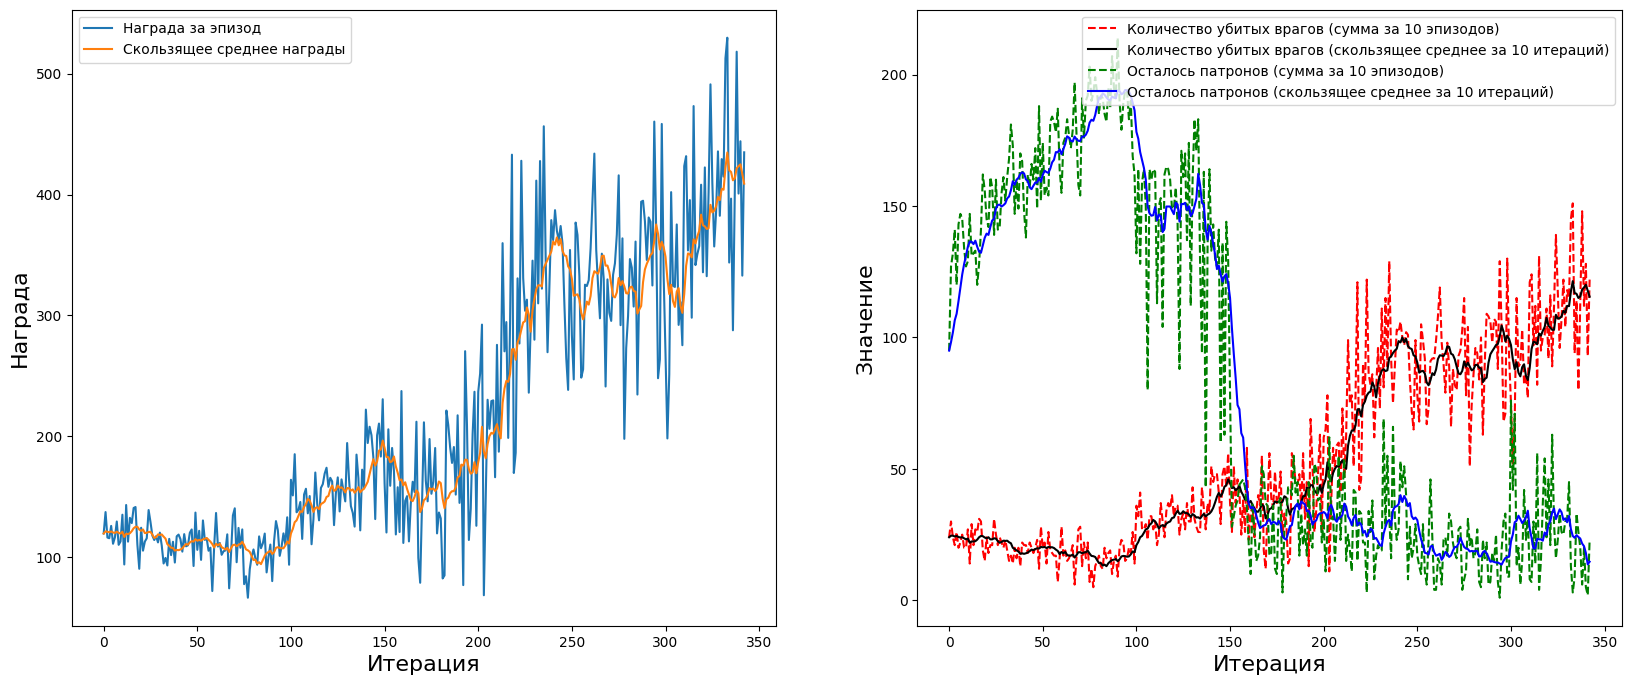

Статистика успешно сохранена.
1/1 [==============================] - 0s 27ms/step
Обучение main_model на текущей истории
1/1 [==============================] - 0s 20ms/step
Обучение main_model на текущей истории
1/1 [==============================] - 0s 21ms/step
Закончился 3430-й эпизод. Значение эпсилон: 0.01, Количество убитых врагов: 18.0, количество оставшихся патронов: 0.0
Текущий размер памяти лучших игр 250, максимум 250
1/1 [==============================] - 0s 31ms/step
Обучение main_model на текущей истории
1/1 [==============================] - 0s 19ms/step
Закончился 3431-й эпизод. Значение эпсилон: 0.01, Количество убитых врагов: 15.0, количество оставшихся патронов: 0.0
Текущий размер памяти лучших игр 250, максимум 250
1/1 [==============================] - 0s 20ms/step
Обучение main_model на текущей истории
1/1 [==============================] - 0s 20ms/step
Обучение main_model на текущей истории
1/1 [==============================] - 0s 35ms/step
Закончился 3432-й эпи

In [ ]:
while episode_number < observation_steps:
    # Увеличиваем номер шага на 1
    timestep += 1
    # Извлекаем индекс награды и новое значение эпсилон
    action_index, epsilon, type_act = get_action(previous_state,
                                                 epsilon,
                                                 final_epsilon,
                                                 epsilon_decay_factor,
                                                 action_size)

    # Приводим награду в onehot массив
    action_onehot = to_categorical(action_index)
    # Подаем действие в игровую среду в качестве списка
    game.set_action(action_onehot.tolist())
    # Игра продвигается на 4 кадра (значение frames_per_action)
    game.advance_action(frames_per_action)
    current_info[3] += frames_per_action

    # Предобрабатываем кадр в (размер 64 х 64 x 1)
    game_data = game.get_state()

    # Проверяем если эпизод закончился
    episode_done = game.is_episode_finished()

    # Нам необходимо возобновить среду и записать нужные статистики когда заканчивается эпизод
    if episode_done:
        interval_kills += current_info[0]      # убили монстров
        interval_ammos += current_info[2]      # патроны

        information = f"Закончился {episode_number}-й эпизод. Значение эпсилон: {round(epsilon, 2)}, "
        information += f"Количество убитых врагов: { current_info[0]+1}, "
        information += f"количество оставшихся патронов: {current_info[2]}"
        print(information)

        episode_number += 1   # Увеличиваем номер эпизода на 1

        ##############################################################################
        ##                  Блок сбора данны best_games                             ##
        ##############################################################################
        # Собираем в пмять лучших выше определенного уровня от лучшей игры
        if episod_reward > best_episod//2:
            # добавляем стек в память лучших игр
            best_games.extend(steck_episode)
            memory_b_exist = True
            k = len(best_games)-1
            print(f'Текущий размер памяти лучших игр {k+1}, максимум {maximum_best_games_length}')
            # сортируем для сожранения лучших и выбытию хдших
            if memory_b_exist and len(list(best_games)) > min_memory:
                best_games = deque(sorted(list(best_games),
                                          key = lambda k : k[5]),
                                          maxlen = maximum_best_games_length)

            # переназначение и сохранение лучшего результата и модели
            if episod_reward > best_episod:
                best_episod = episod_reward
                # Сохраняем веса модели
                print(f'Сохраняем веса модели c best_episod = {episod_reward}')
                main_model.save_weights(SAVE_PATH + '/vizdoom_DQN_model.h5')
                model_weights = True
        # сброс для нового эпизода
        steck_episode = []
        episod_reward = 0
        current_info =  np.zeros(4) #game_data.game_variables
        previous_info = deepcopy(current_info)
        ##############################################################################

        # Чтобы не собирать слишком много данных и чтобы данные было удобно отображать на графике
        # Записываем результат раз в avr_wind = 10 эпизодов
        if episode_number % avr_wind == 0 and episode_number > 0:
            # Добавляем награду в список всех наград
            record_rewards.append(interval_reward)
            # Добавляем количество убитых врагов
            record_kills.append(interval_kills)
            # Добавляем количество неиспользованых патронов
            record_ammos.append(interval_ammos)
            # Записываем результаты в графики
            show_scores(record_rewards, record_kills, record_ammos, window = avr_wind)

            # Записываем статистику в файл через библиотеку pickle
            with open(SAVE_PATH+'/vizdoom_DQN_stats.txt', 'wb') as f:
              pickle.dump([record_rewards, record_kills, record_ammos, episode_number,
                          timestep, epsilon, best_episod], f)
            print("Статистика успешно сохранена.")

            # Заново инициализируем значения статистики для интервала в avr_wind = 10 эпизодов
            interval_reward, interval_kills, interval_ammos = 0, 0, 0


        # Начинаем новый эпизод игры
        game.new_episode()
        # Извлекаем новое состояние игры
        game_data = game.get_state()
        new_episod = True

    # Извлекаем информацию о игровой среде (количество убитых врагов, неиспользованных патронов, текущее здоровие)
    game_info = game_data.game_variables
    #print("game_info", game_info)
    current_info[1] = game_info[1] # здоровье
    current_info[2] = game_info[0] # патроны


    # Извлекаем новый кадр из игры
    frame = game_data.screen_buffer
    # Предобрабатываем кадр (новая размерность будет 64 х 64 х chanels)
    processed_frame = preprocess_frame(frame, chanels)
    processed_frame = np.reshape(processed_frame, (1,64,64, chanels))

    if new_episod:
        current_state =  np.vstack([processed_frame for i in range(num_frames)])
        previous_state = deepcopy(current_state)
        new_episod = False
    else:
        # Обновляем состояние - удаляем последний кадр и добавляем новый
        current_state = np.append(current_state[1:num_frames, :, :, :], processed_frame,  axis = 0)

    # Извлекаем награду за шаг из среды (логика, которую не можем менять)
    environment_reward = game.get_last_reward() # (+1; 0; -1)
    #print("environment_reward", environment_reward)
    if environment_reward == 1: #
       current_info[0] += environment_reward # награда, можно воспринимать как к-во убитых
    else:
       # если живы, то не изменится (т.к 0), а убиты, то уменьшиться (т.к -1)
       current_info[3] += game_step * environment_reward
    #print("живучесть", (previous_info[3], current_info[3]), "относ.живучесть", previous_info[3]/current_info[3])
    #print("current_info[0]", current_info[0])
    # Извлекаем награду за шаг из самописный функции (самописная награда, значит можем менять логику)
    custom_reward = get_reward(previous_info, current_info, episode_done)
    #print("custom_reward", custom_reward)
    # Общая награда - это сумма награды из среды и самописной награды
    reward = environment_reward + custom_reward
    #print("reward", reward)
    # Добавляем предыдущее состояние, действие, награду, и текущее состояние в память
    add_to_memory(previous_state, action_index, reward, current_state, episode_done)
    # Добавляем награду в переменную для статистики
    interval_reward += reward

    ##############################################################################
    ##                     Блок отбора стека эпизода                            ##
    ##############################################################################
    # учет в вознагрждении действия сети или случая, снижается со снижением epsilon
    if type_act: k = 0.9 + epsilon
    else: k = 1
    reward_k = environment_reward + custom_reward*k
    #print("reward_k", reward_k)
    #print()

    # текущий рейтинг эпизода
    episod_reward += reward_k

    # рейтинг фрейма
    reward_frame = np.append(reward_frame[1:], [reward_k],  axis = 0)
    sum_frame = np.sum(reward_frame)

    # отбираем действи увеличивающиеся вознаградения от кадра к кадру
    if  sum_frame > np.sum(last_reward_frame):
        # собираем стек эпизода
        steck_episode.append([previous_state, action_index,
                              reward, current_state, episode_done, sum_frame])

    last_reward_frame = reward_frame
    ##############################################################################

    # Обучаем нашу модель раз в 100 шагов, но только если у нас достаточно данных в памяти
    if timestep % timesteps_per_train == 0:
        print(f'Обучение main_model на текущей истории')
        train_network(main_model, target_model,
                      memory,
                      epsilon = epsilon, part_memory = True)

    # Обновляем целевую модель весами основной модели раз в заданное количество (5000) шагов
    if timestep % target_model_update_frequency == 0:
        if len(best_games) > maximum_best_games_length//5:
            print(f'Обучение main_model на лучших')
            train_network(main_model, target_model,
                          best_games,
                          epsilon = epsilon,  part_memory = False)
        print(f'Обновление весов target_model')
        target_model.load_weights(SAVE_PATH+'/vizdoom_DQN_model.h5')
        gc.collect()

    # Запоминаем предыдущию информацию
    previous_info = deepcopy(current_info)
    # Запоминаем предыдущее состояние
    previous_state = deepcopy(current_state)

